# Pytorch Classification Models

Uptil now we have dealt with predictive algorithms for numerical functions.  
Now we focus on classification models where a particular input is classified to a particular class.  
  
We look in particular at the input-output shapes (features and labels). For eg. in the case of a photo, we could have an input shape of 4 given by:  
Feature Shape = [batch_size, color, width, height]  
  
batch_size => Tells the number of training data that is provided at once  

Label Shape may vary depending on how many classifications are there. Could range from binary to thousands of classifcations.

In [15]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [ ]:
from sklearn.datasets import make_circles

samples = 1000
X, y = make_circles(samples,
                    noise=0.03,
                    random_state=42)

circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})
circles.head(10)

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


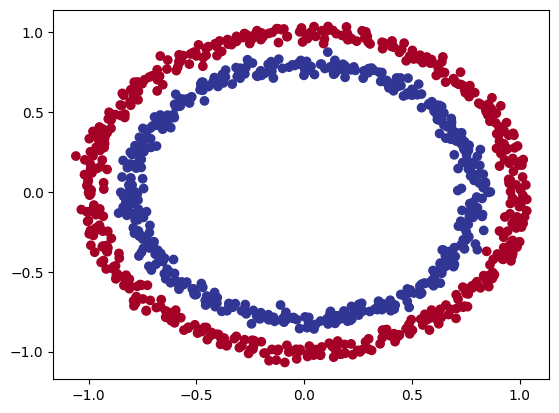

In [17]:
plt.scatter(x = X[:, 0], 
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu) # type: ignore

In [18]:
# Now to convert the arrays into tensors for our model
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

### Building a model
To build a model, we have to do the following things:
1. Set up device agnostic code
2. Set up a model
3. Set up loss fn and optimizer
4. Create a training loop for test samples

In [20]:
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CircleClassification(nn.Module):
    def __init__(self):
        super().__init__()
        # Creating a 3 layered nn: 1 i/p, 1 hidden, 1 o/p
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_circle = CircleClassification().to(device)

# OR 
# WE CAN USE NN.SEQUENTIAL
"""
model_circle = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

# The same sequential can also be added to the Class definition and replace the individual layer 1, layer 2, etc.
"""

next(model_circle.parameters()).device

device(type='cuda', index=0)

In [21]:
# Make predictions
with torch.inference_mode():
    untrain_preds = model_circle(X_test.to(device))
    
print(f"Test Classification given by: {untrain_preds[:10]} || Real predictions: {y_test[:10]}")


Test Classification given by: tensor([[0.8300],
        [1.0107],
        [0.5587],
        [0.9061],
        [0.8798],
        [0.9876],
        [1.2419],
        [1.2373],
        [0.5455],
        [1.0264]], device='cuda:0') || Real predictions: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [22]:
# Setting up Loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() # Works with the Sigmoid Activation Function, good for binary classification

optimizer = torch.optim.SGD(model_circle.parameters(),
                            lr=0.01)

# Setting up an accuracy function
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

### For training the model, we see a sequence of
-> Going from raw logits -> prediction prob. -> prediction labels  
where our model o/p are going to be raw __logits__

These logits are then converted by passing them through either sigmoid activation functions (for binary) or softmax (for multiclass) 

In [23]:
model_circle.eval()
with torch.inference_mode():
    y_logits = model_circle(X_test.to(device))[:5]

y_preds = torch.sigmoid(y_logits)

print(torch.round(y_preds), "\n")
print(y_test[:5])
#torch.round(y_preds) == y_test[:5].to(device)

# OR
# y_preds = torch.round(torch.sigmoid(model_circle(X_test.to(device)[:5])))

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0') 

tensor([1., 0., 1., 0., 1.])


In [24]:
# Now training and testing the model
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    # Training
    model_circle.train()
    
    # Forward pass
    y_logits = model_circle(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    
    # Loss (In the case of BCELosswithLogits, we solely feed the loss function with the logits and not anything further)
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_train, y_pred)
    
    # OPtimizer
    optimizer.zero_grad()
    
    # BackPropAlg
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    # Testing
    if epoch % 50 == 0:
        model_circle.eval()
        with torch.inference_mode():
            test_logit = model_circle(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logit))
            
        test_loss = loss_fn(test_logit, y_test)
        
        print(f"For epoch: {epoch} || Loss: {loss:.5f} with acccuracy: {acc}% || test loss: {test_loss:.5f}")
        
        
    

For epoch: 0 || Loss: 0.78581 with acccuracy: 50.0% || test loss: 0.79649
For epoch: 50 || Loss: 0.74317 with acccuracy: 50.0% || test loss: 0.75032
For epoch: 100 || Loss: 0.72041 with acccuracy: 50.0% || test loss: 0.72523
For epoch: 150 || Loss: 0.70824 with acccuracy: 50.0% || test loss: 0.71150
For epoch: 200 || Loss: 0.70171 with acccuracy: 50.0% || test loss: 0.70393
For epoch: 250 || Loss: 0.69820 with acccuracy: 50.125% || test loss: 0.69970
For epoch: 300 || Loss: 0.69629 with acccuracy: 58.875% || test loss: 0.69730
For epoch: 350 || Loss: 0.69524 with acccuracy: 54.25% || test loss: 0.69591
For epoch: 400 || Loss: 0.69465 with acccuracy: 52.0% || test loss: 0.69509
For epoch: 450 || Loss: 0.69430 with acccuracy: 51.125% || test loss: 0.69459
For epoch: 500 || Loss: 0.69409 with acccuracy: 50.875% || test loss: 0.69427
For epoch: 550 || Loss: 0.69395 with acccuracy: 50.5% || test loss: 0.69406
For epoch: 600 || Loss: 0.69385 with acccuracy: 50.5% || test loss: 0.69392
For ep

__To improve our model, we can change various other quanitities such as:__
- Increasing the number of epochs 
- Changing the activation function
- Increasing the number of hidden layers
- Increasing the number of elements within each layer
- Changing the learning rate
- Changing the loss function  
  
Since these are parameters that are are changed by us, we refer to them as __hyperparameters__

In [25]:
class CircleClassificationV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 20)
        self.layer_2 = nn.Linear(in_features = 20, out_features = 20)
        self.layer_3 = nn.Linear(in_features = 20, out_features = 1)
        self.relu = nn.ReLU()
                
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_circle_2 = CircleClassificationV2().to(device)

# Optimizer and Loss function
loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_circle_2.parameters(),
                            lr=0.005)

In [27]:
# T&T
epochs = 10000

for epoch in range(epochs):
    model_circle_2.train()
    
    # Forward pass
    y_logits = model_circle_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # Loss (In the case of BCELosswithLogits, we solely feed the loss function with the logits and not anything further)
    loss = loss_fn_2(y_logits, y_train)
    acc = accuracy(y_train, y_pred)
    
    # OPtimizer
    optimizer.zero_grad()
    
    # BackPropAlg
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    # Testing
    if epoch % 500 == 0:
        model_circle_2.eval()
        with torch.inference_mode():
            test_logit = model_circle_2(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logit))
            
        test_loss = loss_fn_2(test_logit, y_test)
        
        print(f"For epoch: {epoch} || Loss: {loss:.5f} with acccuracy: {acc}% || test loss: {test_loss:.5f}")
    
    

For epoch: 0 || Loss: 0.62660 with acccuracy: 74.5% || test loss: 0.63573
For epoch: 500 || Loss: 0.61588 with acccuracy: 77.25% || test loss: 0.62642
For epoch: 1000 || Loss: 0.60279 with acccuracy: 80.625% || test loss: 0.61509
For epoch: 1500 || Loss: 0.58700 with acccuracy: 85.5% || test loss: 0.60111
For epoch: 2000 || Loss: 0.56852 with acccuracy: 89.5% || test loss: 0.58472
For epoch: 2500 || Loss: 0.54670 with acccuracy: 93.625% || test loss: 0.56516
For epoch: 3000 || Loss: 0.52057 with acccuracy: 97.125% || test loss: 0.54151
For epoch: 3500 || Loss: 0.49017 with acccuracy: 99.625% || test loss: 0.51420
For epoch: 4000 || Loss: 0.45650 with acccuracy: 99.75% || test loss: 0.48414
For epoch: 4500 || Loss: 0.41654 with acccuracy: 99.75% || test loss: 0.44775
For epoch: 5000 || Loss: 0.37616 with acccuracy: 99.875% || test loss: 0.41032
For epoch: 5500 || Loss: 0.33505 with acccuracy: 99.875% || test loss: 0.37129
For epoch: 6000 || Loss: 0.29444 with acccuracy: 99.875% || test 

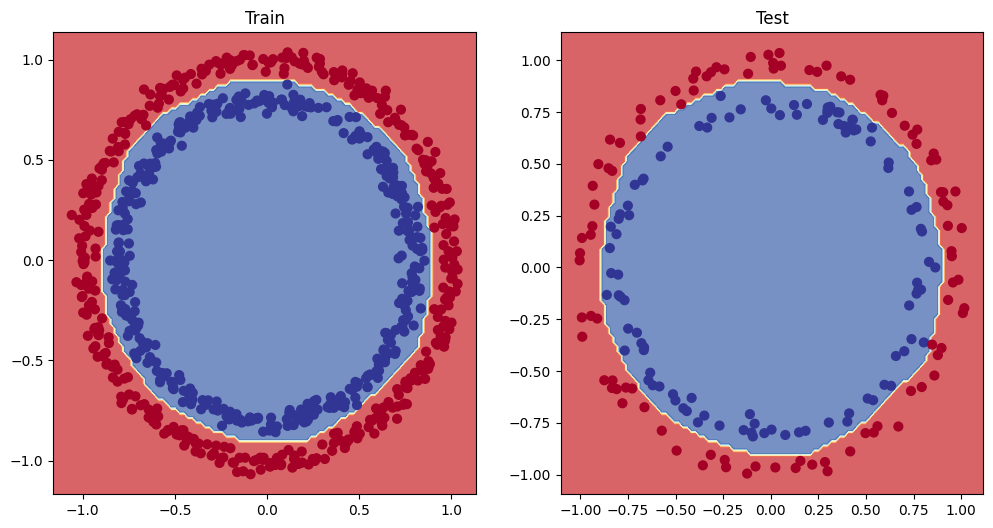

In [33]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_circle_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_circle_2, X_test, y_test)